After loading data from Timber, it has to be preprocessed. It has to be decided when the source was stable, when voltage breakdowns occured an so on. These are tasks that in practice only have to be done once, which is the reason why this notebook exists. One is able to specify a raw data file and this notebook will export a labeled one together with visualizations of the performed tasks so that a visual quality check can be done.

In [1]:
%run ../ionsrcopt/import_notebooks/Setup.ipynb

In [2]:
%run ../ionsrcopt/import_notebooks/Preprocessing.ipynb

First we need to read the data into a dataframe that we will manipulate and save afterwards. We will not do any column preselection at this point.

Because data is only registered when a parameter changes, the datapoints can correspond to a different time duration. When we do the clustering we need to take this into account using some form of weight. We will create a column that gives the duration of a datapoint in seconds.

In [3]:
def timedelta_to_seconds(timedelta):
    if not pd.isnull(timedelta):
        return timedelta.total_seconds()
    else:
        return np.nan
    
def calc_duration(df):
    print("Calculating data point duration")
    
    df[ProcessingFeatures.DATAPOINT_DURATION] = (df.index.to_series().diff(-1)).apply(timedelta_to_seconds).values
    df[ProcessingFeatures.DATAPOINT_DURATION] *= -1
    return df

The next thing we are going to do, is marking the source as stable/unstable. The parameters used are from experiments on the Nov2018 data.

In [4]:
def calc_stability(df):
    print("Calculating source stability")
    
    value_column = SourceFeatures.BCT25_CURRENT
    weight_column = ProcessingFeatures.DATAPOINT_DURATION
    sliding_window_size_mean=1500
    sliding_window_size_std=2000
    minimum_mean=0.015
    #minimum_mean=0.027 #for Nov 2018
    #minimum_mean=0.035 #for Nov 2016
    maximum_variance=0.000035

    df[ProcessingFeatures.SOURCE_STABILITY] = stability_mean_variance_classification(
                                df, 
                                value_column=value_column, 
                                weight_column=weight_column,
                                sliding_window_size_mean=sliding_window_size_mean,
                                sliding_window_size_std=sliding_window_size_std,
                                minimum_mean=minimum_mean, 
                                maximum_variance=maximum_variance)
    return df

The next thing we are interested in are the high voltage breakdowns.

In [5]:
def calc_breakdowns(df):
    print("Searching for HT voltage breakdowns")
    
    column = SourceFeatures.SOURCEHTAQNI
    window_size = 40
    threshold = 0.25

    df[ProcessingFeatures.HT_VOLTAGE_BREAKDOWN] = detect_breakdowns(df, column, window_size, threshold)
    df = df.astype({ProcessingFeatures.HT_VOLTAGE_BREAKDOWN : 'int64'})
    return df

After having done all of this, we can clean the data from values where we cannot tell anything about the source performance. These are all the times where the BCT05 current is (almost zero).

In [6]:
def calc_running(df):
    print("Marking the running periods of the source")
    
    is_zero_threshold = 0.004
    df[ProcessingFeatures.SOURCE_RUNNING] = 0
    df.loc[df[SourceFeatures.BCT05_CURRENT] > is_zero_threshold, ProcessingFeatures.SOURCE_RUNNING] = 1
    return df

All rows that still have NaN values have missing information that can not be aquired from the data. Hence we remove these rows.

In [7]:
def get_outlier_location(df, column, min_v, max_v):
    if min_v is None and max_v is None:
        return (slice(None), column)
    elif max_v is None:
        return (df[column] < min_v, column)
    elif min_v is None:
        return (df[column] > max_v, column)
    else:
        return ((df[column] < min_v) | (df[column] > max_v), column)

def remove_outliers(df):
    if SourceFeatures.BIASDISCAQNV in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.BIASDISCAQNV, -1000, 0)] = np.nan
    if SourceFeatures.GASAQN in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.GASAQN, 0, 100)] = np.nan
    if SourceFeatures.GASSASAQN in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.GASSASAQN, 0, 100)] = np.nan
    if SourceFeatures.SOLINJ_CURRENT in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.SOLINJ_CURRENT, 0, 10000)] = np.nan
    if SourceFeatures.SOLCEN_CURRENT in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.SOLCEN_CURRENT, 0, 10000)] = np.nan
    if SourceFeatures.SOLEXT_CURRENT in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.SOLEXT_CURRENT, 0, 10000)] = np.nan
    if SourceFeatures.OVEN1AQNP in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.OVEN1AQNP, -1000, 0)] = np.nan
    if SourceFeatures.OVEN2AQNP in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.OVEN2AQNP, -1000, 0)] = np.nan
    if SourceFeatures.SOURCEHTAQNI in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.SOURCEHTAQNI, -1, 10)] = np.nan
    if SourceFeatures.SAIREM2_FORWARDPOWER in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.SAIREM2_FORWARDPOWER, 0, 40000)] = np.nan
    if SourceFeatures.THOMSON_FORWARDPOWER in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.THOMSON_FORWARDPOWER, 0, 40000)] = np.nan
    if SourceFeatures.BCT05_CURRENT in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.BCT05_CURRENT, -0.1, 2)] = np.nan
    if SourceFeatures.BCT25_CURRENT in df.columns:
        df.loc[get_outlier_location(df, SourceFeatures.BCT25_CURRENT, -0.1, 0.8)] = np.nan
        
    return df

In [8]:
def preprocess(df):
    df = calc_duration(df)
    df = calc_stability(df)
    df = calc_breakdowns(df)
    df = calc_running(df)
    return df.dropna()

In [51]:
input_file = '../Data_Raw/May2015.csv'
previous_month_file = None
output_file = '../Data_Preprocessed/May2015.csv'

In [52]:
df = read_data_from_csv(input_file, None, None)
df = remove_outliers(df)
df = fill_columns(df, previous_month_file, fill_nan_with_zeros=True)
df = convert_column_types(df)
df.shape

Loading data from csv file '../Data_Raw/May2015.csv'
Forward filling missing values...
Converting column types...


(700936, 11)

In [53]:
df = preprocess(df)

Calculating data point duration
Calculating source stability
Searching for HT voltage breakdowns
Marking the running periods of the source


### Visualizations
#### Source classification

<IPython.core.display.Javascript object>


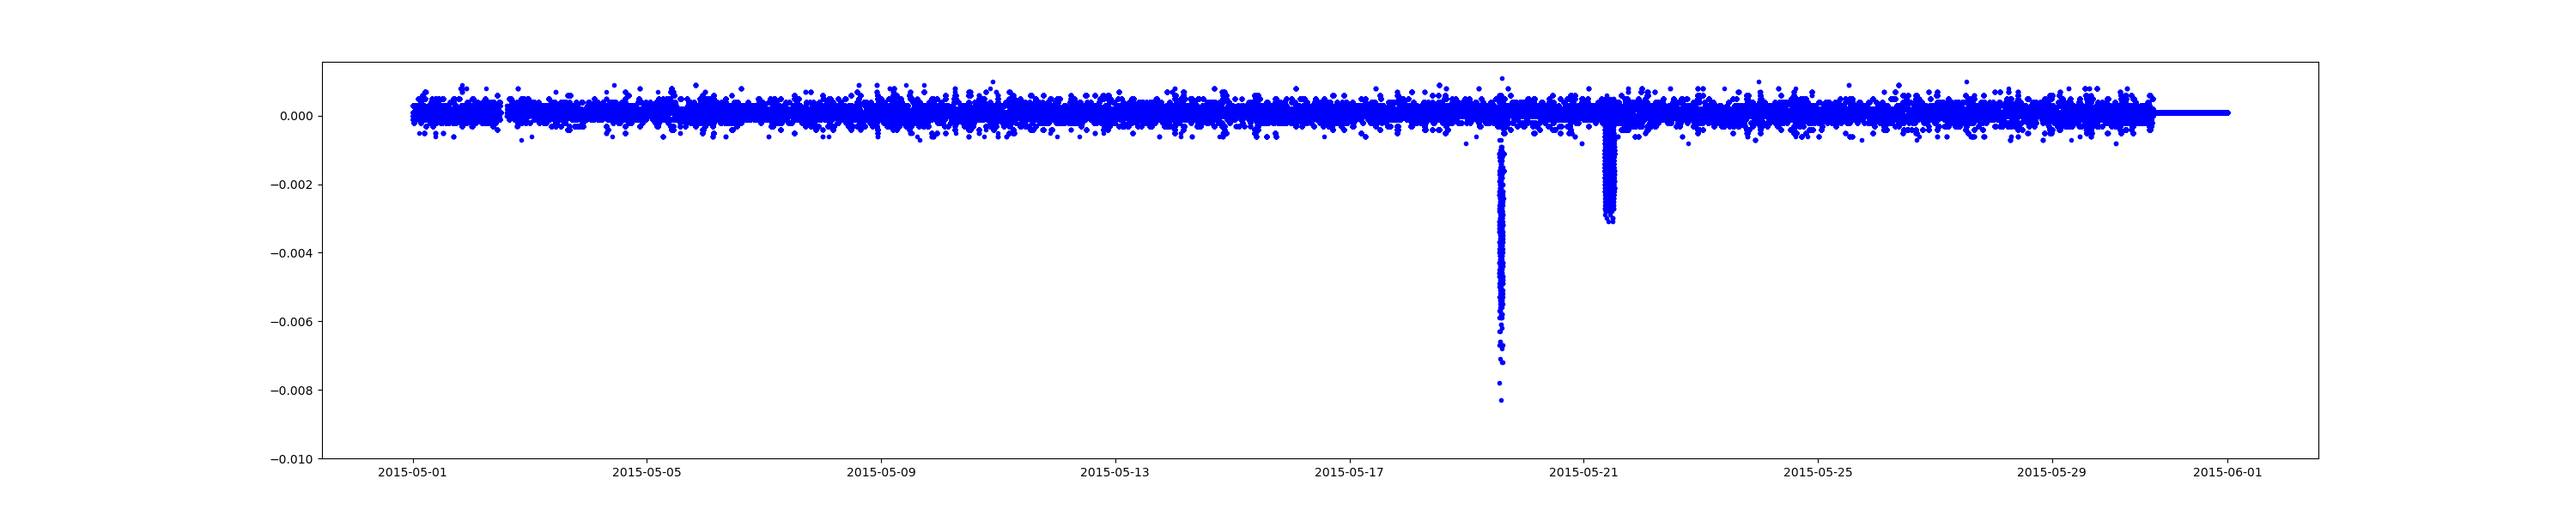

In [54]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (30,6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dates_stable = matplotlib.dates.date2num(df.loc[df[ProcessingFeatures.SOURCE_STABILITY] == 1].index.values)
dates_unstable = matplotlib.dates.date2num(df.loc[df[ProcessingFeatures.SOURCE_STABILITY] == 0].index.values)

fig = plt.figure()
ax = plt.subplot('111')
ax.plot_date(dates_stable, df.loc[df[ProcessingFeatures.SOURCE_STABILITY] == 1, SourceFeatures.BCT25_CURRENT].values, fmt='.', c='orange')
ax.plot_date(dates_unstable, df.loc[df[ProcessingFeatures.SOURCE_STABILITY] == 0, SourceFeatures.BCT25_CURRENT].values, fmt='.', c='blue')
ax.set_ylim(-0.01, None)

plt.show()

#### Voltage Breakdowns

<IPython.core.display.Javascript object>


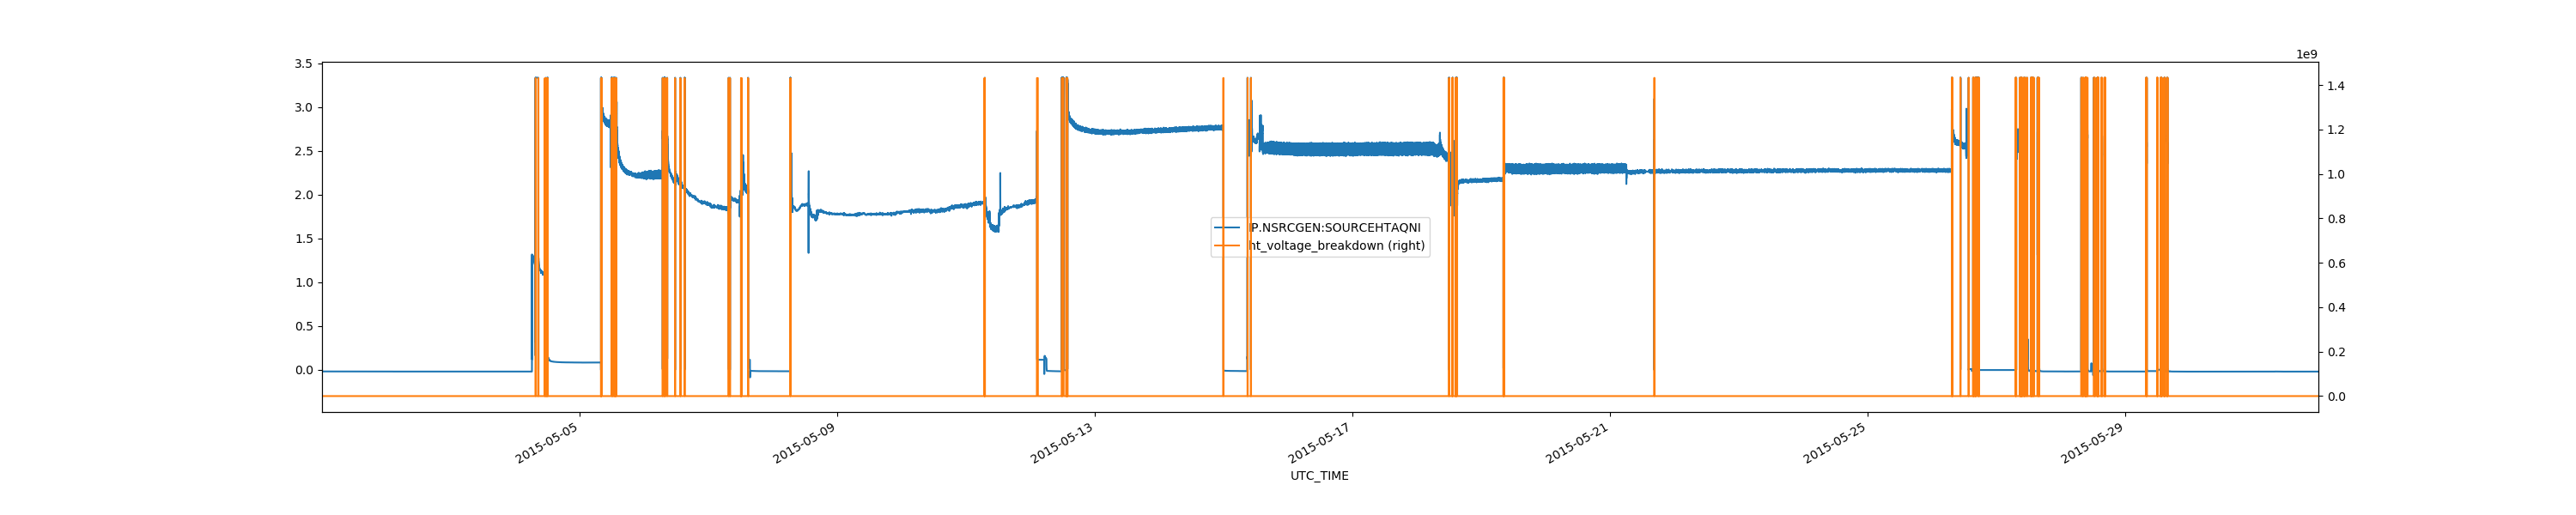

In [55]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)

ax1 = df.plot(y=[SourceFeatures.SOURCEHTAQNI, ProcessingFeatures.HT_VOLTAGE_BREAKDOWN], secondary_y=[ProcessingFeatures.HT_VOLTAGE_BREAKDOWN])
plt.show()

Now we can save the frame as a csv file. To save storage and increase loading time we set consequitve duplicates to nan. This can be reversed while loading using pd.fillna

In [56]:
df[df.shift(1)==df] = np.nan
df.to_csv(output_file)
print("Saved preprocessing of {} to {}.".format(input_file, output_file))

Saved preprocessing of ../Data_Raw/May2015.csv to ../Data_Preprocessed/May2015.csv.
